In [16]:
import matplotlib.pyplot 
import sys
import numpy
import pickle
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import grid_search

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list =  ['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
                  'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                  'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 
                  'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 
                  'from_this_person_to_poi', 'shared_receipt_with_poi'] 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#finding total number of data points
print ("No. of data points:")
print(len(data_dict))

#finding number of features
for key in data_dict.iterkeys():
    print key
    print data_dict[key]
    print "--------------"

#Number of POI and non-POI in the data set
poi_count = 0
non_poi_count = 0
for employee in data_dict:
    for feature,feature_value in data_dict[employee].iteritems():
        if (feature=="poi") & (feature_value==1):
            poi_count+=1
        if (feature=="poi") & (feature_value==0):
            non_poi_count+=1
print "poi_count:", poi_count
print "non_poi_count:",non_poi_count

#Number of people with unknown email address
count_email_ppl=0
for employee in data_dict:
    for feature,feature_value in data_dict[employee].iteritems():
        if (feature=="email_address") & (feature_value=='NaN'):
            count_email_ppl += 1
                
print "No. of people with unknown email address: ",count_email_ppl


No. of data points:
146
METTS MARK
{'salary': 365788, 'to_messages': 807, 'deferral_payments': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'bonus': 600000, 'restricted_stock': 585062, 'shared_receipt_with_poi': 702, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 585062, 'expenses': 94299, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38}
--------------
BAXTER JOHN C
{'salary': 267102, 'to_messages': 'NaN', 'deferral_payments': 1295738, 'total_payments': 5634343, 'exercised_stock_options': 6680544, 'bonus': 1200000, 'restricted_stock': 3942714, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 10623258, 'expenses': 11200, 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 2660303, 'from_this_person_to_poi

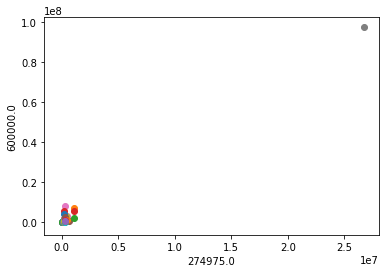

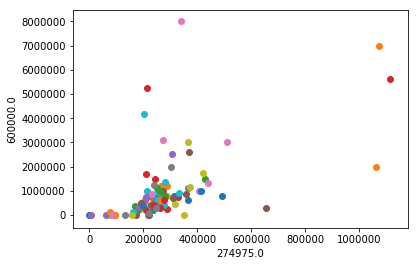

In [17]:
### Task 2: Remove outliers
def scatter_plot(feature1, feature2):   
    data = featureFormat(data_dict, [feature1, feature2])
    for point in data:
        feature1 = point[0]
        feature2 = point[1]
        matplotlib.pyplot.scatter( feature1, feature2 )

    matplotlib.pyplot.xlabel(feature1)
    matplotlib.pyplot.ylabel(feature2)
    matplotlib.pyplot.show()
    
scatter_plot("salary","bonus")
data_dict.pop( "TOTAL", 0 ) # removes the outlier 'TOTAL' from the dictionary
data_dict.pop("THE TRAVEL AGENCY IN THE PARK") # remove non-employee detail
scatter_plot("salary","bonus")


In [24]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

def interactions_with_poi(poi_messages, all_messages):
    percent = 0
    percent = (poi_messages/float(all_messages))*100
    return percent

for employee in my_dataset:         
    from_poi_to_this_person = my_dataset[employee]['from_poi_to_this_person']
    from_this_person_to_poi = my_dataset[employee]['from_this_person_to_poi']
    
    if from_poi_to_this_person != 'NaN' and from_this_person_to_poi != 'NaN':
        poi_messages = my_dataset[employee]['from_poi_to_this_person'] + my_dataset[employee]['from_this_person_to_poi']
    else:
        poi_messages = 999999
    
    to_messages = my_dataset[employee]['to_messages']
    from_messages = my_dataset[employee]['from_messages']
   
    if from_poi_to_this_person != 'NaN' and from_this_person_to_poi != 'NaN':
        all_messages = to_messages + from_messages
    else:
        all_messages = 1
        
    poi_interaction = interactions_with_poi(poi_messages, all_messages)
    my_dataset[employee]['poi_interaction'] = poi_interaction

for employee in my_dataset:
    if my_dataset[employee]['poi_interaction'] > 100:
        my_dataset[employee]['poi_interaction'] = 0
#checking people with more than 10% interaction with poi
#for employee in my_dataset:
#    if my_dataset[employee]['poi_interaction'] >= 10 and my_dataset[employee]['poi_interaction'] <= 100:
#        print(employee)
#        print(my_dataset[employee]['poi_interaction'])

#for employee in my_dataset:
#    salary = my_dataset[employee]['salary']
#    bonus = my_dataset[employee]['bonus'] 

features_list_new = features_list
features_list_new =  features_list_new + ['poi_interaction']
print features_list_new
        
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list_new, sort_keys = True)
labels, features = targetFeatureSplit(data)

['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'poi_interaction']


In [25]:
#univariate feature selection 

def select_second_element(element):
    return element[1]

selector = SelectKBest(f_classif, k = 10)
selector.fit(features, labels)
scores = zip(features_list_new[1:], selector.scores_)
scores_sorted = sorted(scores, key = select_second_element, reverse = True)
print 'Select KBest scores: ', scores_sorted
kBest_features = [(j[0]) for j in scores_sorted[0:10]]
print '\nK Best Features:', kBest_features
kbest_with_poi =  ['poi'] + kBest_features

my_dataset = data_dict

data = featureFormat(my_dataset, kbest_with_poi, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

Select KBest scores:  [('exercised_stock_options', 24.815079733218194), ('total_stock_value', 24.182898678566879), ('bonus', 20.792252047181535), ('salary', 18.289684043404513), ('deferred_income', 11.458476579280369), ('long_term_incentive', 9.9221860131898225), ('restricted_stock', 9.2128106219771002), ('total_payments', 8.7727777300916756), ('shared_receipt_with_poi', 8.589420731682381), ('loan_advances', 7.1840556582887247), ('expenses', 6.0941733106389453), ('poi_interaction', 5.399370288094409), ('from_poi_to_this_person', 5.2434497133749582), ('other', 4.1874775069953749), ('from_this_person_to_poi', 2.3826121082276739), ('director_fees', 2.1263278020077054), ('to_messages', 1.6463411294420076), ('deferral_payments', 0.22461127473600989), ('from_messages', 0.16970094762175533), ('restricted_stock_deferred', 0.065499652909942141)]

K Best Features: ['exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'deferred_income', 'long_term_incentive', 'restricted_stock', 'to

In [26]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Try a variety of classifiers.

features_train, features_test, labels_train, labels_test = \
    cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
    
# Naive Bayes 
print "Naive Bayes"
clf1 = GaussianNB()
t0 = time()
clf1.fit(features_train, labels_train)

print "Training time:", round(time()-t0, 3), "s"
t1 = time()
pred = clf1.predict(features_test)
print "Predicting time:", round(time()-t1, 3), "s"

nb_score = clf1.score(features_test, labels_test)
nb_accuracy = accuracy_score(labels_test, pred)
nb_precision = precision_score(labels_test, pred)
nb_recall = recall_score(labels_test, pred)
print "Accuracy: ", nb_accuracy
print "Precision:", nb_precision
print "Recall: ", nb_recall

#Support Vector Machine
print "\nSVM"
clf2 = SVC(kernel='linear', C = 1, gamma= 1)
t0 = time()
clf2.fit(features_train, labels_train) 
print "Training time:", round(time()-t0, 3), "s"

t1 = time()
pred = clf2.predict(features_test)
print "Predicting time:", round(time()-t1, 3), "s"

SVC_score = clf2.score(features_test, labels_test)
SVC_accuracy = accuracy_score(labels_test, pred)
SVC_precision = precision_score(labels_test, pred)
SVC_recall = recall_score(labels_test, pred)
print "Accuracy: ", SVC_accuracy
print "Precision:", SVC_precision
print "Recall: ", SVC_recall

# Decision Tree
print "\nDecision Tree"
clf3 = tree.DecisionTreeClassifier(criterion='gini', splitter='best')
t0 = time()
clf3.fit(features_train, labels_train)
print "Training time:", round(time()-t0, 3), "s"

t1 = time()
pred = clf3.predict(features_test)
print "Predicting time:", round(time()-t1, 3), "s"

tree_score = clf3.score(features_test, labels_test)
tree_accuracy = accuracy_score(labels_test, pred)
tree_precision = precision_score(labels_test, pred)
tree_recall = recall_score(labels_test, pred)
print "Accuracy: ", tree_accuracy
print "Precision:", tree_precision
print "Recall: ", tree_recall

# KNeighbors
print "\nKNeighbors"
clf4 = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform', algorithm = 'auto')
t0 = time()
clf4.fit(features_train, labels_train)
print "Training time:", round(time()-t0, 3), "s"

t1 = time()
pred = clf4.predict(features_test)
print "Predicting time:", round(time()-t1, 3), "s"

KN_score = clf3.score(features_test, labels_test)
KN_accuracy = accuracy_score(labels_test, pred)
KN_precision = precision_score(labels_test, pred)
KN_recall = recall_score(labels_test, pred)
print "Accuracy: ", KN_accuracy
print "Precision:", KN_precision
print "Recall: ", KN_recall

#AdaBoost
print "\nAdaBoost"
clf5 = AdaBoostClassifier(n_estimators=10)
t0 = time()
clf5.fit(features_train, labels_train)
print "Training time:", round(time()-t0, 3), "s"

t1 = time()
pred = clf5.predict(features_test)
print "Predicting time:", round(time()-t1, 3), "s"

ab_score = clf5.score(features_test, labels_test)
ab_accuracy = accuracy_score(labels_test, pred)
ab_precision = precision_score(labels_test, pred)
ab_recall = recall_score(labels_test, pred)
print "RF accuracy: ", ab_accuracy
print "RF precision: ", ab_precision
print "RF recall: ", ab_recall

#Random Forest
print "\nRandomForest"
clf6 = RandomForestClassifier(n_estimators = 1, criterion = "entropy" )
t0 = time()
clf6.fit(features_train, labels_train)
print "Training time:", round(time()-t0, 3), "s"

t1 = time()
pred = clf6.predict(features_test)
print "Predicting time:", round(time()-t1, 3), "s"

rf_score = clf6.score(features_test, labels_test)
rf_accuracy = accuracy_score(labels_test, pred)
rf_precision = precision_score(labels_test, pred)
rf_recall = recall_score(labels_test, pred)
print "RF accuracy: ", rf_accuracy
print "RF precision: ", rf_precision
print "RF recall: ", rf_recall

Naive Bayes
Training time: 0.002 s
Predicting time: 0.001 s
Accuracy:  0.860465116279
Precision: 0.4
Recall:  0.4

SVM
Training time: 0.001 s
Predicting time: 0.0 s
Accuracy:  0.883720930233
Precision: 0.0
Recall:  0.0

Decision Tree
Training time: 0.001 s
Predicting time: 0.0 s
Accuracy:  0.813953488372
Precision: 0.2
Recall:  0.2

KNeighbors
Training time: 0.001 s
Predicting time: 0.002 s
Accuracy:  0.790697674419
Precision: 0.166666666667
Recall:  0.2

AdaBoost
Training time: 0.021 s
Predicting time: 0.003 s
RF accuracy:  0.744186046512
RF precision:  0.125
RF recall:  0.2

RandomForest
Training time: 0.004 s
Predicting time: 0.002 s
RF accuracy:  0.883720930233
RF precision:  0.5
RF recall:  0.2


In [27]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
def optimal_parameters(classifier, parameters):
    clf = grid_search.GridSearchCV(classifier, parameters, scoring='f1')
    clf.fit(features_train, labels_train)
    print clf.best_params_
    
# SVM
svm_parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svm = SVC()
print ("SVM")
optimal_parameters(svm, svm_parameters)

# Decision Tree
parameters = {
    'criterion':('gini', 'entropy'),
    'splitter':('best','random')
}
dt = tree.DecisionTreeClassifier()
print ("\nDecision Tree") 
optimal_parameters(dt, parameters)

# KNeighbors
kn_parameters = {
    'n_neighbors': [1, 10, 50], 
    'weights':('uniform', 'distance'), 
    'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute')
}
kn = KNeighborsClassifier()
print ("\nK Neighbors Classifier")
optimal_parameters(kn, kn_parameters)

#AdaBoostClassifier 
ab_parameters = {
    'n_estimators': [1, 10, 50], 
}
ab = AdaBoostClassifier()
print ("\nAdaBoost Classifier")
optimal_parameters(ab, ab_parameters)

#RandomForestClassifier
parameters = {
    'criterion':('gini', 'entropy'),
    'n_estimators':[1, 10, 100]
}
rf =RandomForestClassifier()
print ("\nRandom Forest")
optimal_parameters(rf, parameters)

SVM
{'kernel': 'linear', 'C': 1}

Decision Tree
{'splitter': 'random', 'criterion': 'gini'}

K Neighbors Classifier
{'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto'}

AdaBoost Classifier
{'n_estimators': 10}

Random Forest
{'n_estimators': 1, 'criterion': 'entropy'}


In [32]:
clf = clf1
features_list = kBest_features

In [33]:
from sklearn.cross_validation import StratifiedShuffleSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of labels for any class cannot be less than 2.

In [34]:

test_classifier(clf, my_dataset, features_list)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of labels for any class cannot be less than 2.

In [35]:
dump_classifier_and_data(clf, my_dataset, features_list)